# Tarea 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, bisect
from scipy.constants import Boltzmann
from scipy.interpolate import CubicSpline

## Experiencia 1

Extraimos los datos del primer circuito en un dataframe

In [2]:
datos=pd.read_table('circuito1.txt',header=0)

Graficamos

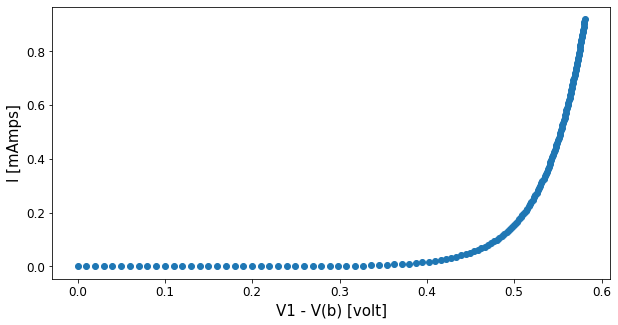

In [19]:
V = datos['v1']-datos['V(n002)']
I = datos['I(D1)']

plt.figure(figsize=(10,5))
plt.plot(V, 1000*I, 'o')
plt.xlabel('V1 - V(b) [volt]', size=15)
plt.ylabel('I [mAmps]', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Definimos la funcion para realizar el ajuste: 

$$I(V) = a(e^{bV}-1)$$

En donde $a=I_0$ y $b = \frac{q}{KT}$

In [360]:
# Constantes:
K = Boltzmann
q = 1.602176634*(10**-19) # Coulomb

def corriente_I(V, a, b):
    return a*(np.exp(b*V)-1)

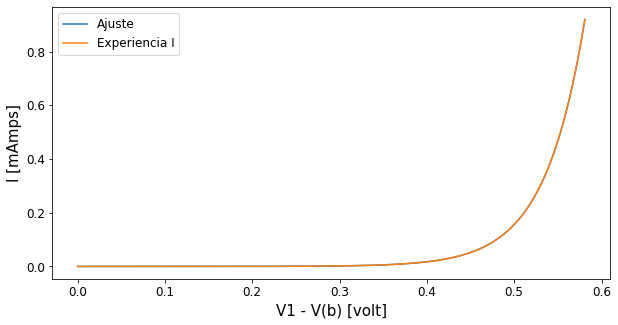

I_0 =  2.7016782478780414e-09
T =  529.1817203119546


In [361]:
# fiteo
I_fit = curve_fit(corriente_I, V, I)
I_teo = corriente_I(V, I_fit[0][0], I_fit[0][1])

# graficamos
plt.figure(figsize=(10,5))
plt.plot(V, 1000*I_teo, label='Ajuste')
plt.plot(V, 1000*I, label='Experiencia I')
plt.xlabel('V1 - V(b) [volt]', size=15)
plt.ylabel('I [mAmps]', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 12})
plt.show()

print('I_0 = ', I_fit[0][0] )
print('T = ', q/(K*I_fit[0][1]))

In [362]:
RMS = np.sqrt(sum((I_teo-I)**2)/(len(I)))
print('Raiz del Error cuadrático medio:', RMS*1000, '[mAmps]')

Raiz del Error cuadrático medio: 0.0002644361495808102 [mAmps]


Expresion para $V_{out}$ :

$$V_{out} = R I_0 ( e^{\frac{(V_{in}-V_{out})q}{KT}} - 1)$$

Encontraremos los ceros para la funcion:

$$g(V_{out}) = V_{out} = R I_0 ( e^{(V_{in}-V_{out})b} - 1) - V{out}$$

con $b = \frac{q}{KT}$, de modo que lo ceros de esta funcion sean los $V_{out}$ que satisfacen la primera ecuacion

In [363]:
# Constantes
R = 1000
I0 = I_fit[0][0]
b = I_fit[0][1]

# voltaje de entrada y salida
V_in = datos['v1']
V_out=np.zeros(len(V_in))

# funcion que se buscara ceros
def g(v_out):
    return R*I0*(np.exp((V_in[i]-v_out)*b)-1) - v_out

for i in range(len(V_in)):
    V_out[i] = bisect(g,10,-10)

Visualicemos los datos para $V_{out}$ obtenidos de LTSPICE

In [364]:
V_outLTspice = datos['V(n002)']
V_outLTspice

0      0.000000e+00
1      6.222022e-07
2      1.398011e-06
3      2.365343e-06
4      3.571466e-06
           ...     
146    8.810652e-01
147    8.905734e-01
148    9.000865e-01
149    9.096044e-01
150    9.191271e-01
Name: V(n002), Length: 151, dtype: float64

Graficamos el medido en LTSPICE y el obtenido con la ecuación:

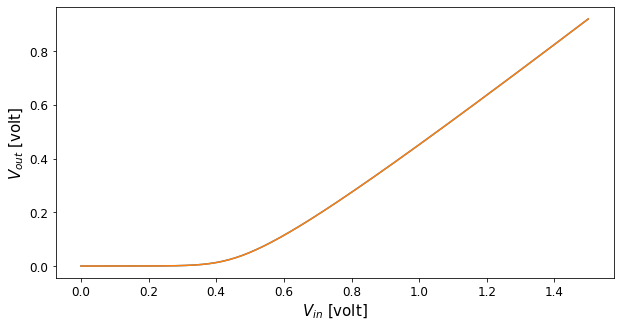

In [365]:
plt.figure(figsize=(10,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(V_in, V_out, label='Ajuste')
plt.plot(V_in, V_outLTspice, label='Experiencia I')
plt.xlabel('$V_{in}$ [volt]', size=15)
plt.ylabel('$V_{out}$ [volt]', size=15)
#plt.legend(prop={'size': 12})
plt.show()

Extrapolamos $V_{out}$ con CubicSpline para calcular la derivada

In [366]:
# pasamos a array
V_in = np.array(V_in)

# expandimos
Vind = np.append(V_in, [1.51, 1.52, 1.53])

# extrapolamos
cs = CubicSpline(V_in, V_out)

Voutd = cs(Vind)

Calcula las derivadas:

In [367]:
dV_out  = np.zeros(len(Voutd))
d2V_out = np.zeros(len(Voutd))
d3V_out = np.zeros(len(Voutd))
d4V_out = np.zeros(len(Voutd))

for i in range(len(V_out)):
    # V_in[i+1] - V_in[i] = constante = 0.01
    h = V_in[1]-V_in[0]
    
    # primera derivada
    dV_out[i]  = (Voutd[i+1]-Voutd[i])/(h)
    
    # segunda derivada
    d2V_out[i] = (dV_out[i+1]-dV_out[i])/(h)
    
    # tercera derivada
    d3V_out[i] = (d2V_out[i+1]-d2V_out[i])/(h)
    
    # cuarta derivada
    d4V_out[i] = (d3V_out[i+1]-d3V_out[i])/(h)
    
# necesitamos los arrays correspondientes a V_in en [0, 1.5]
dV_out  = dV_out[:151]
d2V_out = d2V_out[:151]
d3V_out = d3V_out[:151]
d4V_out = d4V_out[:151]

Calculamos el radio de curvatura y el radio minimo

In [368]:
R_c = abs((1+dV_out**2)**(3/2))/abs(d2V_out)
i = np.where( R_c==min(R_c))
print('El radio minimo es: ', '{:.3F}'.format(float(R_c[i])),
      ', que corresponde a un V_in = ', '{:.3F}'.format(float(V_in[i])),
      ' y un V_out = ', '{:.3F}'.format(float(V_out[i])))

El radio minimo es:  0.026 , que corresponde a un V_in =  0.590  y un V_out =  0.107


## Experiencia 2

Al variar DC Offset se obtienen las frecuencias el segundo armonico:

In [241]:
P_sec    = np.array([-87.346, -69.003, -53.25, -42.943, -38.22, -37.82, -41.43, -47.002,  -52.583, -57.053, -60.750, -64.501, -67.199, -70.060, -72.633, -74.421])
V_offset = np.array([0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1, 1.2, 1.3, 1.4, 1.5 ])

Text(0.5, 0, 'DC Offset [volt]')

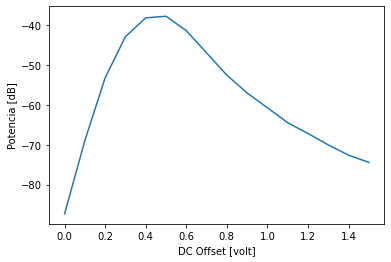

In [242]:
plt.plot(V_offset, P_sec, '-')
plt.ylabel('Potencia [dB]')
plt.xlabel('DC Offset [volt]')

Vemos que el maximo valor para la potencia del segundo armonico es cuando $V_{offset} = 0.5$ V y $P_{II} = -37.82$ dB

## DC Offset = 0.3

In [396]:
datos3=pd.read_table('circuito3clean.txt',header=0, sep=' ')

Text(0, 0.5, '$V_out$ [dB]')

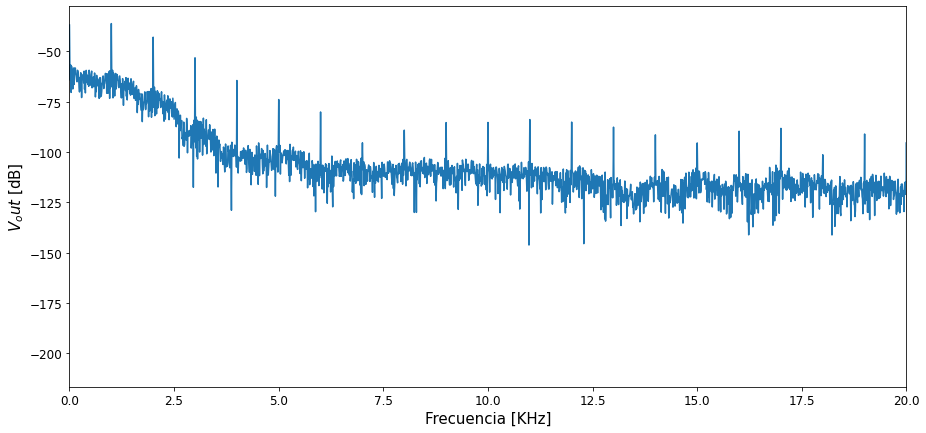

In [397]:
plt.figure(figsize=(15,7))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(datos3['Freq.']/1000, datos3['V(out)'])
plt.xlim(0,20)
plt.xlabel('Frecuencia [KHz]', size=15)
plt.ylabel('$V_out$ [dB]', size=15)

## DC offset = 0.5

Extraemos los datos

In [297]:
datos2=pd.read_table('circuito2clean.txt',header=0, sep=' ')

Graficamos

Text(0, 0.5, '$V_out$ [dB]')

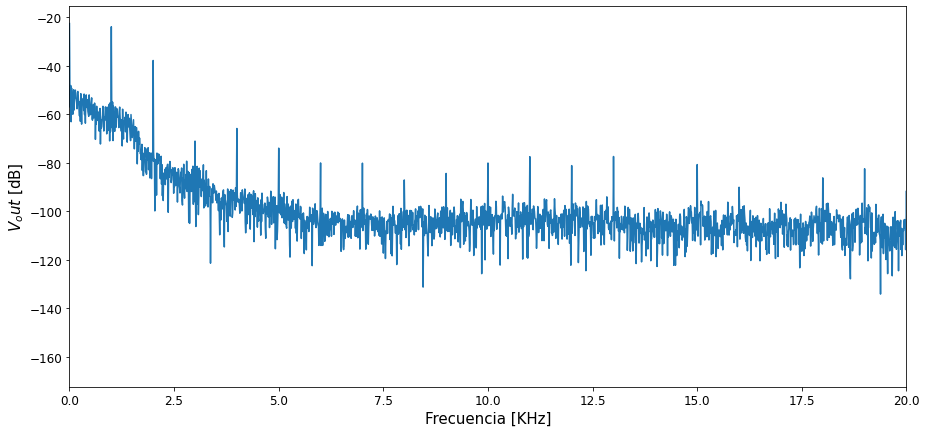

In [298]:
plt.figure(figsize=(15,7))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(datos2['Freq.']/1000, datos2['V(out)'])
plt.xlim(0,20)
plt.xlabel('Frecuencia [KHz]', size=15)
plt.ylabel('$V_out$ [dB]', size=15)

Calculemos la frecuencia de los armonicos:

In [401]:
def armonicos(datos, n):
    freqs = np.zeros(n)
    for i in range(n):
        j = np.where( datos['Freq.']==(i+1)*1000)[0][0]
        freqs[i] = datos2['V(out)'][j]
    return freqs

# primeros 3 armonicos:
arm = armonicos(datos2, 3)

Ahora hacemos Taylor en torno a $V_{0}=0.5$V y con $V_{in}= cos(\omega t) + V_0$

In [389]:
# evaluamos las derivadas:
i = 50
V = V_out[50]
dV  = dV_out[50]
d2V = d2V_out[50]
d3V = d3V_out[50]
d4V = d4V_out[50]

Talor:

$$V_{out}(V_{in} \approx V_0) = V + \frac{d^2V}{4} + \frac{d^4V}{96} - \frac{d^4V}{192} + cos(\omega t) (\frac{d^2V}{4} + dV - \frac{d^3V}{12}) + cos(2\omega t) (\frac{d^3V}{12} - \frac{d^4V}{48}) + cos(4 \omega t) (\frac{d^4V}{192})$$

En donde $d^nV$ representa la derivada $n$-esima de $V_{out}$ respecto a $V_{in}$, evaluado en $V_{in}=0.5$ V. Posteriormente debemos evaluar los coeficientes que acompañan a cada $cos(n \omega t)$:

In [398]:
coef1 = d2V/4 + dV - d3V/12
coef2 = d3V - d4V/48
coef4 = d4V/192

In [402]:
coef1/arm[0]

19.378085327430014

In [403]:
coef2/arm[1]

-440.7458114262309

In [404]:
coef4/arm[2]

39.629527119633735